### Análise de Séries Temporais

A análise de séries temporais compreende métodos para analisar dados de séries temporais para extrair estatísticas significativas e outras características dos dados. A previsão de séries temporais é o uso de um modelo para prever valores futuros com base em valores observados anteriormente.
As séries temporais são amplamente utilizadas para dados não estacionários, como economia, clima, preço das ações e vendas no varejo. Demonstraremos diferentes abordagens para prever séries temporais de produção.

### Importando bibliotecas necessárias

In [345]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

### Importando os dados

In [346]:
df = pd.read_excel("D:/GMN/fbprophet/producao_2015_2021.xlsx")

### Tratando tipo de dados

In [347]:
df['servico_nome'] = df['servico_nome'].str.strip()

In [348]:
df['data_da_os'] = pd.to_datetime(df['data_da_os'])

In [349]:
df['data_da_os'] = pd.to_datetime(df['data_da_os']).dt.date

In [350]:
df['data_da_os'] = pd.to_datetime(df['data_da_os'])

### Observando características da base de dados

In [351]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63516 entries, 0 to 63515
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   convenio              63516 non-null  object        
 1   os_serie              63516 non-null  int64         
 2   os_numero             63516 non-null  int64         
 3   data_da_os            63516 non-null  datetime64[ns]
 4   classe_codigo         63516 non-null  int64         
 5   classe_nome           63516 non-null  object        
 6   servico_nome          63516 non-null  object        
 7   quantidade_principal  63516 non-null  int64         
 8   valor                 63516 non-null  float64       
 9   valor_agregado        63516 non-null  float64       
 10  valor_total           63516 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 5.3+ MB


### Criando base de dados específica para o serviço CINTILOGRAFIA OSSEA (CORPO TOTAL)

In [352]:
cintilografia_ossea_corpo_total = df.loc[df['servico_nome'] == 'CINTILOGRAFIA OSSEA    (CORPO TOTAL)']

### Observando os dados

In [353]:
df.groupby(['servico_nome']).agg({'quantidade_principal':'sum'}).sort_values(['quantidade_principal'], ascending=False).round(2)

,quantidade_principal
servico_nome,
CINTILOGRAFIA OSSEA (CORPO TOTAL),11760
DETECÇAO INTRAOPER RADIOGUIADA LESAO TUM,8322
DEMARCAÇÃO RADIOISOTÓPICA DE LESÕES TUMORAIS (MAMA),6075
CINTILOGRAFIA DO MIOCARDIO PERFUSAO-ESTRESSE,5354
CINTILOGRAFIA DO MIOCARDIO PERFUSAO-REPO,5142
...,...
CINTILOGRAFIA ARTICULACOES E/OU EXTREMID,1
CONSULTA AVALIACAO XOFIGO 1 VEZ,1
"CATETER PERIFERICO PTFE-ANGIOCATH 24G 0.75"" 38833614",1


In [354]:
cintilografia_ossea_corpo_total.head()

,convenio,os_serie,os_numero,data_da_os,classe_codigo,classe_nome,servico_nome,quantidade_principal,valor,valor_agregado,valor_total
8,CENTRAL NAC UNIMED,115,3,2015-01-05,3131,CINTILOGRAFIA OSSEA,CINTILOGRAFIA OSSEA (CORPO TOTAL),1,137.61,174.50,312.11
12,CASSI,115,6,2015-01-05,3131,CINTILOGRAFIA OSSEA,CINTILOGRAFIA OSSEA (CORPO TOTAL),1,199.06,174.50,373.56
13,PLANSERV,115,7,2015-01-05,3131,CINTILOGRAFIA OSSEA,CINTILOGRAFIA OSSEA (CORPO TOTAL),1,141.75,126.01,267.76
14,HAPVIDA,115,8,2015-01-05,3131,CINTILOGRAFIA OSSEA,CINTILOGRAFIA OSSEA (CORPO TOTAL),1,136.89,174.50,311.39
19,SAUDE BRADESCO,115,11,2015-01-05,3131,CINTILOGRAFIA OSSEA,CINTILOGRAFIA OSSEA (CORPO TOTAL),1,131.59,174.50,306.09


### Observando a primeira e última Ordem de Serviço emitidas para o período compreendido

In [355]:
cintilografia_ossea_corpo_total['data_da_os'].min(), cintilografia_ossea_corpo_total['data_da_os'].max()

(Timestamp('2015-01-05 00:00:00'), Timestamp('2021-12-30 00:00:00'))

### Pré-processamento de dados
#### Esta etapa inclui remover colunas desnecessárias, verificar valores ausentes, agregar vendas por data e assim por diante.

In [356]:
cols = ['convenio', 'os_numero', 'classe_codigo', 'classe_nome', 'servico_nome', 'quantidade_principal', 'valor', 'valor_agregado']
cintilografia_ossea_corpo_total.drop(cols, axis=1, inplace=True)
cintilografia_ossea_corpo_total = cintilografia_ossea_corpo_total.sort_values('data_da_os')
cintilografia_ossea_corpo_total.isnull().sum()

os_serie       0
data_da_os     0
valor_total    0
dtype: int64

### Indexação com dados de série temporal

In [357]:
cintilografia_ossea_corpo_total = cintilografia_ossea_corpo_total.groupby('data_da_os')['valor_total'].sum().reset_index()

In [358]:
cintilografia_ossea_corpo_total = cintilografia_ossea_corpo_total.set_index('data_da_os')
cintilografia_ossea_corpo_total.index

DatetimeIndex(['2015-01-05', '2015-01-06', '2015-01-08', '2015-01-13',
               '2015-01-15', '2015-01-19', '2015-01-20', '2015-01-21',
               '2015-01-22', '2015-01-23',
               ...
               '2021-12-18', '2021-12-20', '2021-12-21', '2021-12-22',
               '2021-12-23', '2021-12-24', '2021-12-27', '2021-12-28',
               '2021-12-29', '2021-12-30'],
              dtype='datetime64[ns]', name='data_da_os', length=1621, freq=None)

Os dados de data e hora atuais podem ser difíceis de trabalhar, portanto, será utilizado o valor médio de produção diária para cada mês e o início de cada mês como o carimbo de data/hora.

In [359]:
y = cintilografia_ossea_corpo_total['valor_total'].resample('MS').mean()

### Observando a produção a partir de 2015

In [360]:
y['2015':]

data_da_os
2015-01-01    2531.674286
2015-02-01    2088.441667
2015-03-01    1880.883000
2015-04-01    2343.685333
2015-05-01    2114.794000
                 ...     
2021-08-01    3197.253889
2021-09-01    3315.663636
2021-10-01    3084.545000
2021-11-01    4115.101852
2021-12-01    2959.055417
Freq: MS, Name: valor_total, Length: 84, dtype: float64

### Visualizando Dados de Séries Temporais para o serviço CINTILOGRAFIA OSSEA (CORPO TOTAL)

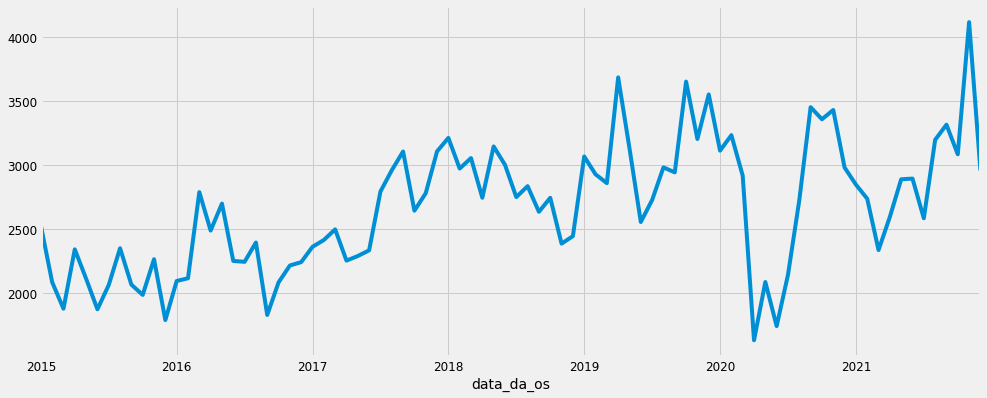

In [361]:
y.plot(figsize=(15, 6))
plt.show()

Alguns padrões distinguíveis aparecem quando plotamos os dados. A série temporal tem padrão de sazonalidade, ao decorrer dos anos. Há sempre uma tendência de alta no primeiro semestre na maioria dos anos.

Também podemos visualizar nossos dados usando um método chamado decomposição de séries temporais que nos permite decompor nossas séries temporais em três componentes distintos: tendência, sazonalidade e ruído.

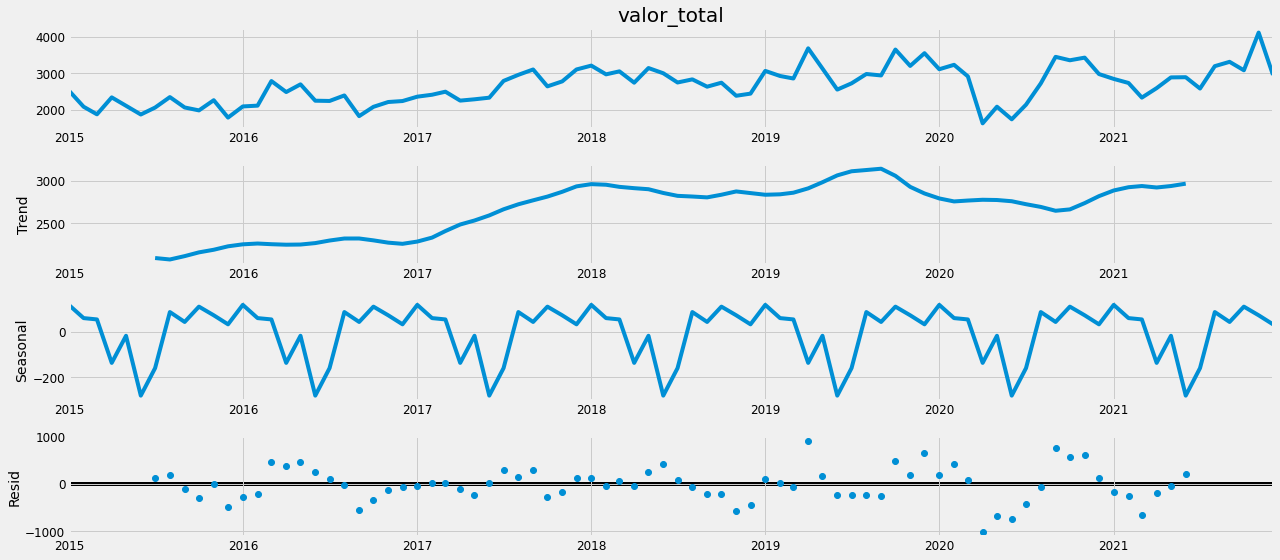

In [362]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

O gráfico acima mostra claramente que a produção a partir do serviço CINTILOGRAFIA OSSEA (CORPO TOTAL) é instável, juntamente com sua óbvia sazonalidade.

### Previsão de séries temporais com ARIMA

Vamos aplicar um dos métodos mais usados ​​para previsão de séries temporais, conhecido como ARIMA, que significa Autoregressive Integrated Moving Average.

Os modelos ARIMA são indicados com a notação ARIMA(p, d, q). Esses três parâmetros são responsáveis ​​pela sazonalidade, tendência e ruído nos dados:

In [363]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


Esta etapa é a seleção de parâmetros para o modelo de série temporal ARIMA de produção para o serviço CINTILOGRAFIA OSSEA (CORPO TOTAL). o objetivo é usar uma “pesquisa de grade” para encontrar o conjunto ideal de parâmetros que produz o melhor desempenho para o modelo.

In [364]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1550.0385028294875
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1265.1275844507786
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1110.2286021762077
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:922.4064112926712
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1126.2407429003208
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1101.4849145860971
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:934.1119308382199
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:920.7536478358362
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1434.7637972747043
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1180.2623019163455
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1080.871531461633
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:891.7684628926867
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1112.80841002845
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1071.748016134107
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:918.6325341816649
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:891.2426458610169
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1215.9549558752096
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1045.4959322281854
AR

A saída acima sugere que SARIMAX (1, 1, 1)x(1, 1, 1, 12) produz o AIC valor mais baixo de 869,40. Portanto, deve-se considerar isso como a opção ideal.

### Ajustando o modelo ARIMA

In [365]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5156      0.161      3.197      0.001       0.199       0.832
ma.L1         -0.9473      0.072    -13.242      0.000      -1.088      -0.807
ar.S.L12      -0.5702      0.134     -4.247      0.000      -0.833      -0.307
sigma2      2.056e+05   3.29e+04      6.253      0.000    1.41e+05     2.7e+05


Deve-se sempre executar diagnósticos de modelo para investigar qualquer comportamento incomum.

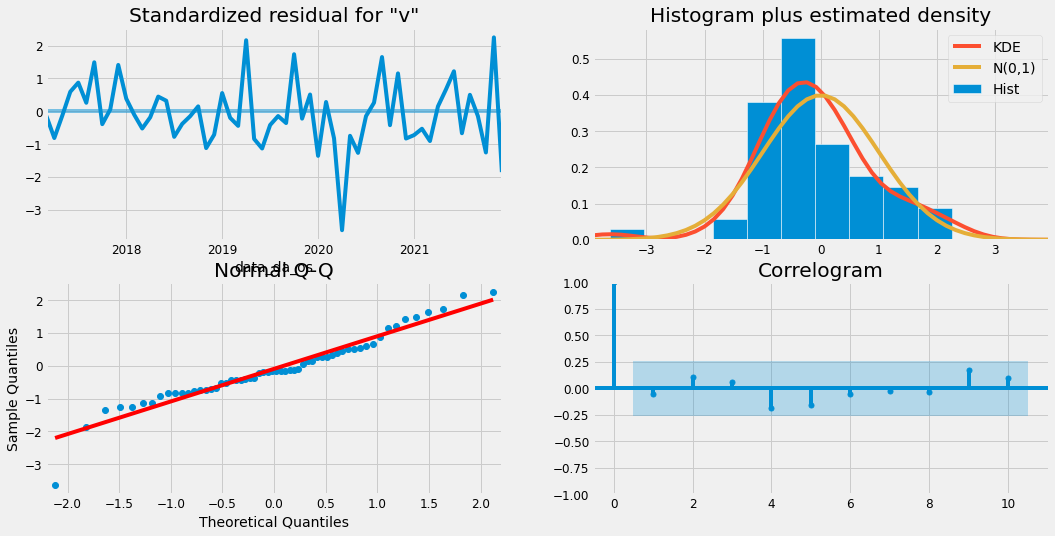

In [366]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

Não é perfeito, no entanto, o diagnóstico do modelo sugere que os resíduos estão distribuídos quase normalmente.

### Validando previsões

Para ajudar a entender a precisão das previsões, comparamos as vendas previstas com as vendas reais da série temporal e definimos as previsões para começar em 2015–01–01 até o final dos dados.

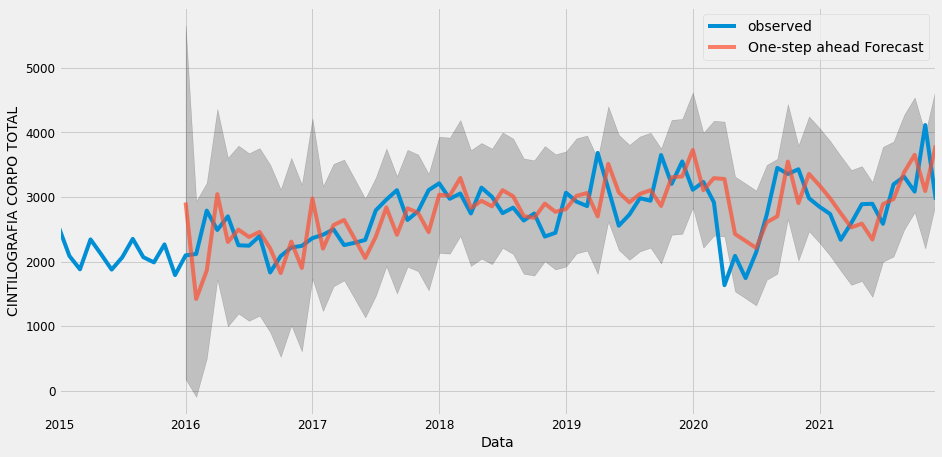

In [367]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Data')
ax.set_ylabel('CINTILOGRAFIA CORPO TOTAL')
plt.legend()

plt.show()

O gráfico de linha está mostrando os valores observados em comparação com as previsões de previsão contínuas. No geral, nossas projeções se alinham muito bem com os valores reais, mostrando uma tendência de alta desde o início do ano e capturando a sazonalidade até o final do ano.

In [368]:
y_forecasted = pred.predicted_mean
y_truth = y['2015-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 212469.78


O erro quadrático médio de nossas previsões é 280592,31

In [369]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 460.94


O erro quadrático médio da raiz de nossas previsões é 529,71

Em estatística, o erro quadrático médio (MSE) de um estimador mede a média dos quadrados dos erros – ou seja, a diferença quadrática média entre os valores estimados e o que é estimado. O MSE é uma medida da qualidade de um estimador — é sempre não negativo, e quanto menor o MSE, mais perto estamos de encontrar a linha de melhor ajuste.

Root Mean Square Error (RMSE) nos diz que nosso modelo foi capaz de prever a média diária de vendas de móveis no conjunto de teste dentro de 529,71 das vendas reais. As produções diárias variam de cerca de 2.500 a mais de 3.3000.

### Produção e visualização de previsões

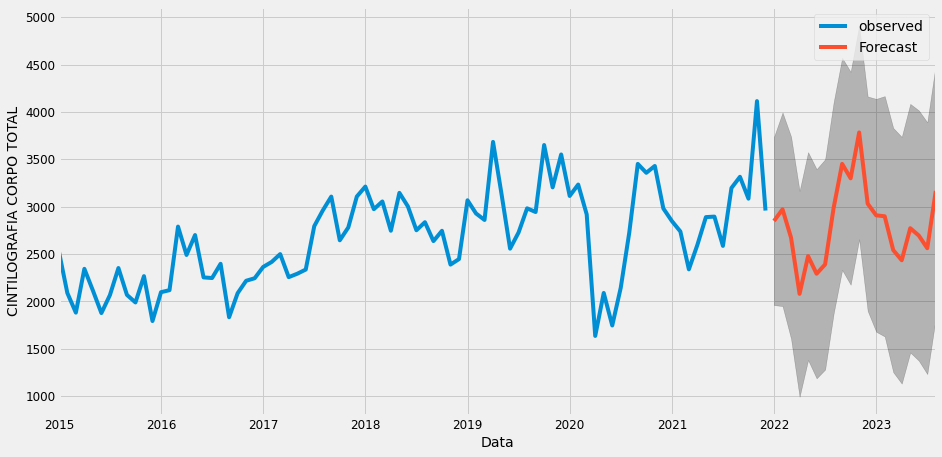

In [370]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data')
ax.set_ylabel('CINTILOGRAFIA CORPO TOTAL')

plt.legend()
plt.show()

Nosso modelo captou claramente a sazonalidade daprodução de Cintilografia Óssea de Corpo Total. À medida que projetamos mais para o futuro, é natural que nos tornemos menos confiantes em nossos valores. Isso se reflete nos intervalos de confiança gerados pelo nosso modelo, que aumentam à medida que avançamos no futuro.

### Série Temporal de Cintilografia Ossea Corpo Total x Cintilografia de Mama

De acordo com nossos dados, houve muito mais Cintilografia de Corpo Total do que Cintilografia de Mama ao longo dos anos.

In [371]:
cintilografia_ossea_corpo_total = df.loc[df['servico_nome'] == 'CINTILOGRAFIA OSSEA    (CORPO TOTAL)']
cintilografia_mama = df.loc[df['servico_nome'] == 'CINTILOGRAFIA DE MAMA BILATERAL']
cintilografia_ossea_corpo_total.shape, cintilografia_mama.shape

((11760, 11), (4984, 11))

### Exploração de dados

Vamos comparar as produções de duas categorias no mesmo período. Isso significa combinar dois quadros de dados em um e plotar as séries temporais dessas duas categorias em um gráfico.

In [372]:
cols = ['convenio', 'os_numero', 'classe_codigo', 'classe_nome', 'servico_nome', 'quantidade_principal', 'valor', 'valor_agregado']
cintilografia_ossea_corpo_total.drop(cols, axis=1, inplace=True)
cintilografia_mama.drop(cols, axis=1, inplace=True)

#### Corpo Total

In [373]:
cintilografia_ossea_corpo_total.head()

,os_serie,data_da_os,valor_total
8,115,2015-01-05,312.11
12,115,2015-01-05,373.56
13,115,2015-01-05,267.76
14,115,2015-01-05,311.39
19,115,2015-01-05,306.09


#### Mama

In [374]:
cintilografia_mama.head()

,os_serie,data_da_os,valor_total
0,114,2015-02-02,947.16
2,114,2015-01-14,947.16
4,114,2015-01-14,947.16
6,115,2015-01-05,728.29
20,115,2015-01-05,728.29


In [375]:
cintilografia_ossea_corpo_total = cintilografia_ossea_corpo_total.set_index('data_da_os')
cintilografia_mama = cintilografia_mama.set_index('data_da_os')

y_cintilografia_ossea_corpo_total = cintilografia_ossea_corpo_total['valor_total'].resample('MS').mean()
y_cintilografia_mama = cintilografia_mama['valor_total'].resample('MS').mean()

cintilografia_ossea_corpo_total = pd.DataFrame({'data_da_os':y_cintilografia_ossea_corpo_total.index, 'valor_total':y_cintilografia_ossea_corpo_total.values})
cintilografia_mama = pd.DataFrame({'data_da_os':y_cintilografia_mama.index, 'valor_total':y_cintilografia_mama.values})


store = cintilografia_ossea_corpo_total.merge(cintilografia_mama, how='inner', on='data_da_os')
store.rename(columns={'valor_total_x': 'cintilografia_ossea_corpo_total_prod', 'valor_total_y': 'cintilografia_mama_prod'}, inplace=True)
store.head()

,data_da_os,cintilografia_ossea_corpo_total_prod,cintilografia_mama_prod
0,2015-01-01,319.310270,796.825490
1,2015-02-01,321.298718,793.603000
2,2015-03-01,321.518462,793.706885
3,2015-04-01,328.554019,735.286346
4,2015-05-01,323.692959,754.066444


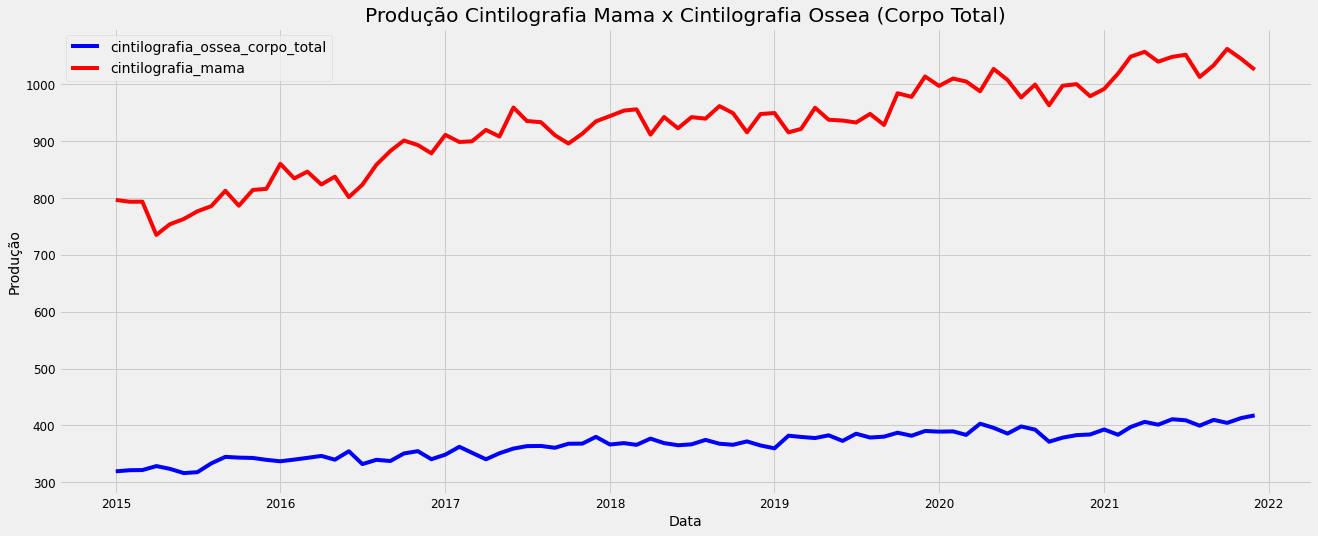

In [376]:
plt.figure(figsize=(20, 8))
plt.plot(store['data_da_os'], store['cintilografia_ossea_corpo_total_prod'], 'b-', label = 'cintilografia_ossea_corpo_total')
plt.plot(store['data_da_os'], store['cintilografia_mama_prod'], 'r-', label = 'cintilografia_mama')
plt.xlabel('Data'); plt.ylabel('Produção'); plt.title('Produção Cintilografia Mama x Cintilografia Ossea (Corpo Total)')
plt.legend();

Observamos que as produções de corpo total e mamas compartilharam um padrão sazonal semelhante. No início do ano é a entressafra para ambas as duas categorias. Além disso, as produções médias diárias de mama são superiores às de corpo total na maioria dos meses. É compreensível, pois o valor de mama deve ser muito superior ao de corpo total.

### Modelagem de Séries Temporais com Prophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

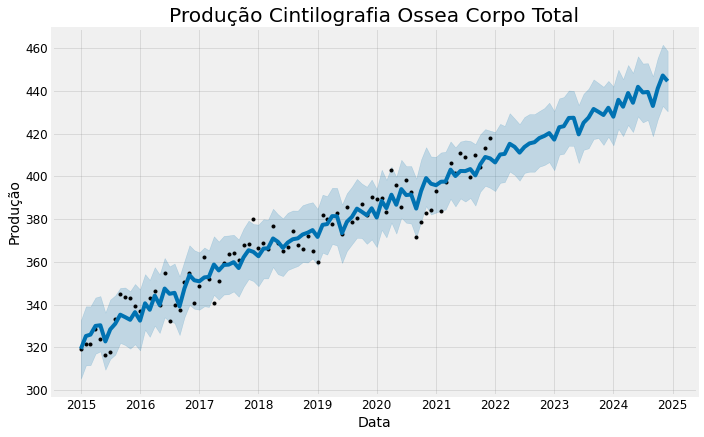

In [377]:
from fbprophet import Prophet

cintilografia_ossea_corpo_total = cintilografia_ossea_corpo_total.rename(columns={'data_da_os': 'ds', 'valor_total': 'y'})
cintilografia_ossea_corpo_total_model = Prophet(interval_width=0.95)
cintilografia_ossea_corpo_total_model.fit(cintilografia_ossea_corpo_total)

cintilografia_mama = cintilografia_mama.rename(columns={'data_da_os': 'ds', 'valor_total': 'y'})
cintilografia_mama_model = Prophet(interval_width=0.95)
cintilografia_mama_model.fit(cintilografia_mama)

cintilografia_ossea_corpo_total_forecast = cintilografia_ossea_corpo_total_model.make_future_dataframe(periods=36, freq='MS')
cintilografia_ossea_corpo_total_forecast = cintilografia_ossea_corpo_total_model.predict(cintilografia_ossea_corpo_total_forecast)

cintilografia_mama_forecast = cintilografia_mama_model.make_future_dataframe(periods=36, freq='MS')
cintilografia_mama_forecast = cintilografia_mama_model.predict(cintilografia_mama_forecast)

plt.figure(figsize=(18, 6))
cintilografia_ossea_corpo_total_model.plot(cintilografia_ossea_corpo_total_forecast, xlabel = 'Data', ylabel = 'Produção')
plt.title('Produção Cintilografia Ossea Corpo Total');

<Figure size 1296x432 with 0 Axes>

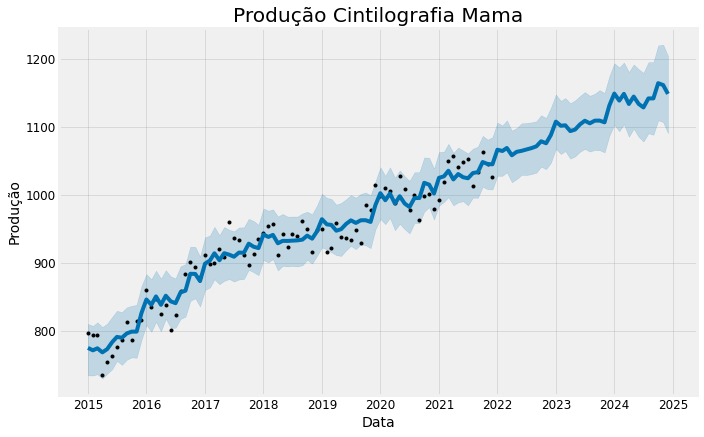

In [378]:
plt.figure(figsize=(18, 6))
cintilografia_mama_model.plot(cintilografia_mama_forecast, xlabel = 'Data', ylabel = 'Produção')
plt.title('Produção Cintilografia Mama');

In [379]:
cintilografia_ossea_corpo_total_forecast = cintilografia_ossea_corpo_total_model.make_future_dataframe(periods=36, freq='MS')

In [380]:
cintilografia_ossea_corpo_total_forecast = cintilografia_ossea_corpo_total_model.predict(cintilografia_ossea_corpo_total_forecast)

<Figure size 1296x432 with 0 Axes>

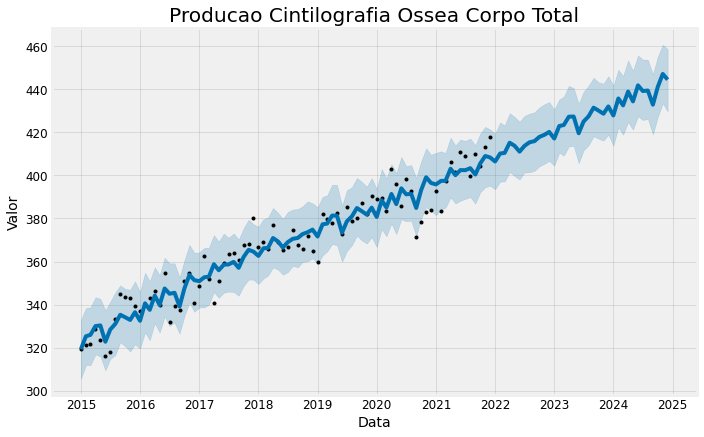

In [381]:
plt.figure(figsize=(18, 6))
cintilografia_ossea_corpo_total_model.plot(cintilografia_ossea_corpo_total_forecast, xlabel = 'Data', ylabel = 'Valor')
plt.title('Producao Cintilografia Ossea Corpo Total');

In [382]:
cintilografia_mama_forecast = cintilografia_mama_model.make_future_dataframe(periods=36, freq='MS')

In [383]:
cintilografia_mama_forecast = cintilografia_mama_model.predict(cintilografia_mama_forecast)

<Figure size 1296x432 with 0 Axes>

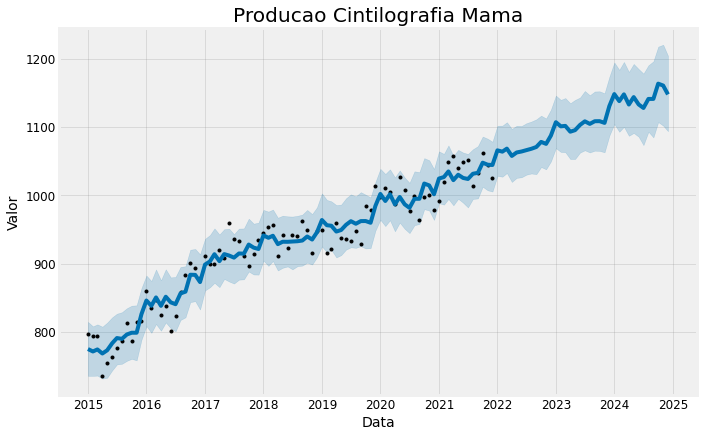

In [384]:
plt.figure(figsize=(18, 6))
cintilografia_mama_model.plot(cintilografia_mama_forecast, xlabel = 'Data', ylabel = 'Valor')
plt.title('Producao Cintilografia Mama');

### Comparar previsões

Já temos as previsões de três anos para essas duas categorias no futuro. Agora vamos juntá-los para comparar suas previsões futuras.

In [385]:
cintilografia_ossea_corpo_total_names = ['cintilografia_ossea_corpo_total_%s' % column for column in cintilografia_ossea_corpo_total_forecast.columns]
cintilografia_mama_names = ['cintilografia_mama_%s' % column for column in cintilografia_mama_forecast.columns]

merge_cintilografia_ossea_corpo_total_forecast = cintilografia_ossea_corpo_total_forecast.copy()
merge_cintilografia_mama_forecast = cintilografia_mama_forecast.copy()

merge_cintilografia_ossea_corpo_total_forecast.columns = cintilografia_ossea_corpo_total_names

merge_cintilografia_mama_forecast.columns = cintilografia_mama_names

forecast = pd.merge(merge_cintilografia_ossea_corpo_total_forecast, merge_cintilografia_mama_forecast, how = 'inner', left_on = 'cintilografia_ossea_corpo_total_ds', right_on = 'cintilografia_mama_ds')

forecast = forecast.rename(columns={'cintilografia_ossea_corpo_total_ds': 'Data'}).drop('cintilografia_mama_ds', axis=1)

forecast.head()

,Data,cintilografia_ossea_corpo_total_trend,cintilografia_ossea_corpo_total_yhat_lower,cintilografia_ossea_corpo_total_yhat_upper,cintilografia_ossea_corpo_total_trend_lower,cintilografia_ossea_corpo_total_trend_upper,cintilografia_ossea_corpo_total_additive_terms,cintilografia_ossea_corpo_total_additive_terms_lower,cintilografia_ossea_corpo_total_additive_terms_upper,cintilografia_ossea_corpo_total_yearly,...,cintilografia_mama_additive_terms,cintilografia_mama_additive_terms_lower,cintilografia_mama_additive_terms_upper,cintilografia_mama_yearly,cintilografia_mama_yearly_lower,cintilografia_mama_yearly_upper,cintilografia_mama_multiplicative_terms,cintilografia_mama_multiplicative_terms_lower,cintilografia_mama_multiplicative_terms_upper,cintilografia_mama_yhat
0,2015-01-01,322.525780,305.579342,332.840305,322.525780,322.525780,-3.273923,-3.273923,-3.273923,-3.273923,...,16.569520,16.569520,16.569520,16.569520,16.569520,16.569520,0.0,0.0,0.0,774.768826
1,2015-02-01,323.755790,311.944918,338.331217,323.755790,323.755790,1.505111,1.505111,1.505111,1.505111,...,7.379887,7.379887,7.379887,7.379887,7.379887,7.379887,0.0,0.0,0.0,771.232033
2,2015-03-01,324.866766,311.838430,338.681468,324.866766,324.866766,1.049445,1.049445,1.049445,1.049445,...,5.242562,5.242562,5.242562,5.242562,5.242562,5.242562,0.0,0.0,0.0,774.200499
3,2015-04-01,326.096776,316.813370,343.405756,326.096776,326.096776,3.896832,3.896832,3.896832,3.896832,...,-6.390423,-6.390423,-6.390423,-6.390423,-6.390423,-6.390423,0.0,0.0,0.0,768.220353
4,2015-05-01,327.287108,315.902470,342.661316,327.287108,327.287108,3.006131,3.006131,3.006131,3.006131,...,-7.132981,-7.132981,-7.132981,-7.132981,-7.132981,-7.132981,0.0,0.0,0.0,772.948284


### Visualização de tendências e previsões

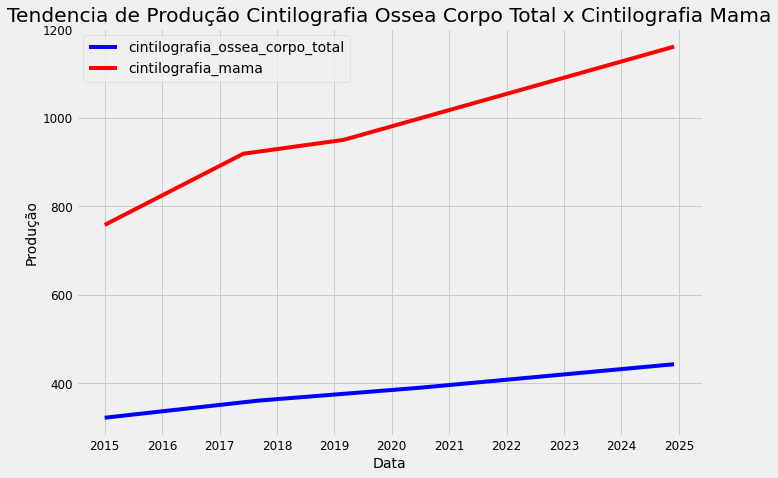

In [386]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Data'], forecast['cintilografia_ossea_corpo_total_trend'], 'b-', label = 'cintilografia_ossea_corpo_total')
plt.plot(forecast['Data'], forecast['cintilografia_mama_trend'], 'r-', label = 'cintilografia_mama')
plt.legend()
plt.xlabel('Data')
plt.ylabel('Produção')
plt.title('Tendencia de Produção Cintilografia Ossea Corpo Total x Cintilografia Mama');

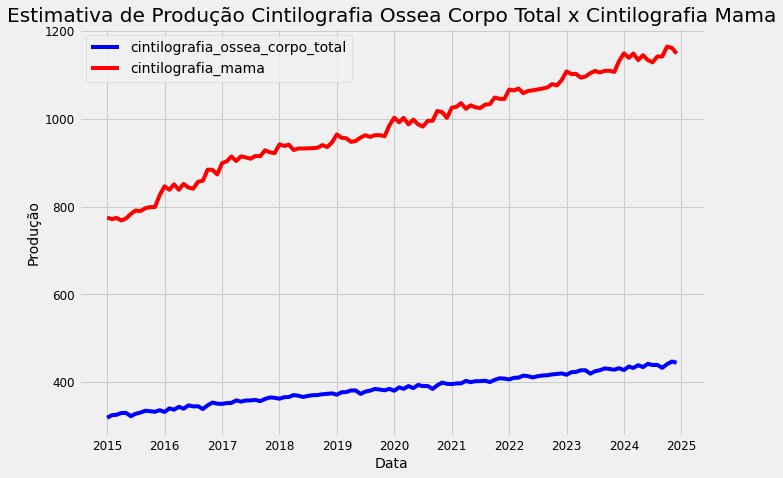

In [387]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['Data'], forecast['cintilografia_ossea_corpo_total_yhat'], 'b-', label = 'cintilografia_ossea_corpo_total')
plt.plot(forecast['Data'], forecast['cintilografia_mama_yhat'], 'r-', label = 'cintilografia_mama')
plt.legend(); plt.xlabel('Data'); plt.ylabel('Produção')
plt.title('Estimativa de Produção Cintilografia Ossea Corpo Total x Cintilografia Mama');

### Tendências e padrões

Agora, podemos usar os Modelos do Prophet para inspecionar diferentes tendências dessas duas categorias nos dados.

### Corpo Total

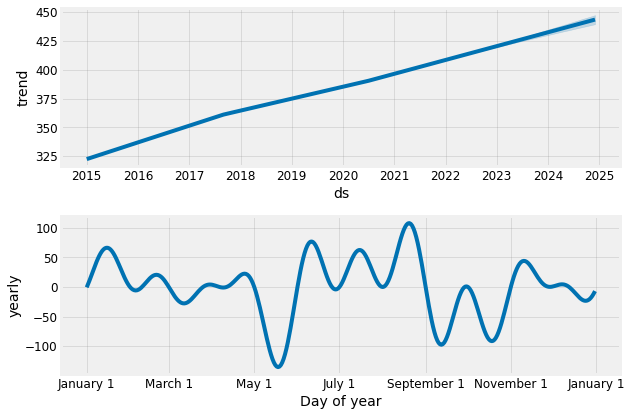

In [388]:
cintilografia_ossea_corpo_total_model.plot_components(cintilografia_ossea_corpo_total_forecast);

### Mama

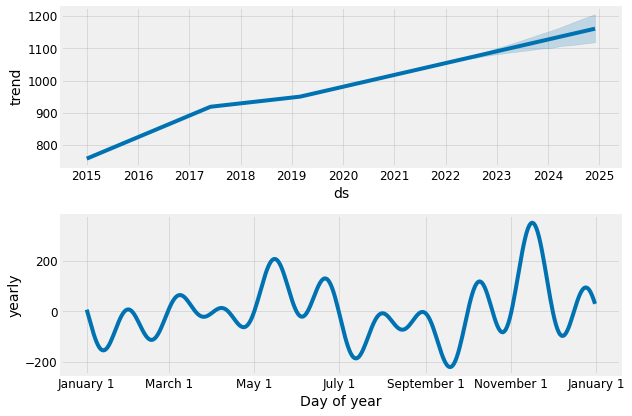

In [389]:
cintilografia_mama_model.plot_components(cintilografia_mama_forecast);

### Valores Reais e Preditivos para Corpo Total

In [390]:
forecast[['Data','cintilografia_ossea_corpo_total_yhat','cintilografia_ossea_corpo_total_trend']].head()

,Data,cintilografia_ossea_corpo_total_yhat,cintilografia_ossea_corpo_total_trend
0,2015-01-01,319.251857,322.525780
1,2015-02-01,325.260901,323.755790
2,2015-03-01,325.916211,324.866766
3,2015-04-01,329.993608,326.096776
4,2015-05-01,330.293238,327.287108


### Valores Reais e Preditivos para Mama

In [391]:
forecast[['Data','cintilografia_mama_yhat','cintilografia_mama_trend']].head()

,Data,cintilografia_mama_yhat,cintilografia_mama_trend
0,2015-01-01,774.768826,758.199307
1,2015-02-01,771.232033,763.852146
2,2015-03-01,774.200499,768.957936
3,2015-04-01,768.220353,774.610775
4,2015-05-01,772.948284,780.081265


### Correlação Entre as Cintilografias Ósseas de Corpo Total e de Mamas

In [392]:
corr = store.corr()
corr.style.background_gradient(cmap='coolwarm')

,cintilografia_ossea_corpo_total_prod,cintilografia_mama_prod
cintilografia_ossea_corpo_total_prod,1.000000,0.922213
cintilografia_mama_prod,0.922213,1.000000


In [393]:
import os

os.system('jupyter nbconvert --to html --no-input forecast_prophet.ipynb')
#os.system('jupyter nbconvert --to html analise_producao_clion_jan_mai_2021.ipynb')

0